# 10 classes

In [84]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression as LR
from keras.datasets import mnist
import itertools
import codecs
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action = 'ignore', category = FutureWarning)

In [85]:
def factorial(n):
    if n == 0:
        return 1
    elif n > 0:
        return n*factorial(n - 1)

In [86]:
# entropy labelling
def tsallis_label(q, probas, s_cls):
    elements = np.power(probas, q - 1)
    # thrshld in tsallis entropy model
    ts_thrshld = np.sum(np.power(probas, q))
    if q < 1:
        labels = [s_cls[i] for i, e in enumerate(elements) if e < ts_thrshld]
    else:
        labels = [s_cls[i] for i, e in enumerate(elements) if e > ts_thrshld]
    return labels

In [87]:
# labelling and evaluating them
def info_trans_scoring_1(q, classes, orig_A, lim_A):
    s_cls = classes

    # extract dataset of chosen classes
    trn_imgs = [img for i, img in enumerate(train_imgs) if train_labels[i] in s_cls]
    trn_labels = [label for label in train_labels if label in s_cls]

    # generate an annotator
    a1_model = LR().fit(trn_imgs[:orig_A], trn_labels[:orig_A])
    a1_probas = a1_model.predict_proba(trn_imgs[orig_A:orig_A + lim_A])

    # entropy labelling
    mul_labels = [tsallis_label(q, probas, s_cls) for probas in a1_probas]
    
    # scoring info transmission
    score = 0
    for labels, probas in zip(mul_labels, a1_probas):
        u_dist = 1/len(labels)
        for label in labels:
            score += np.power(probas[label] - u_dist, 2)
    
    return score

In [88]:
# loading MNIST
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_imgs = np.array([x.ravel() for x in train_images])
test_imgs = np.array([y.ravel() for y in test_images])
img_SIZE = train_images.shape[1]*train_images.shape[2]

### q = -1.0, -0.1, 1.0 

In [99]:
# main measurement
# classes = [i for i in range(10)]
classes = [i for i in range(4)]
orig_A1, lim_A1 = 2000, 2000

fact_10 = factorial(10)

q_list = [-1.0, -0.1, 0.1]

results = [info_trans_scoring_1(q, classes, orig_A1, lim_A1) for q in q_list]
print(results)

[603.7175203036727, 35.82850944335943, 8.541073928440824]


### q = 0 (1/M)

In [91]:
# 1/M labelling
def oneMth_label(probas, s_cls):
    # 1/M
    thrshld = 1/len(s_cls)
    labels = [s_cls[i] for i, pk in enumerate(probas) if pk > thrshld]
    return labels

# labelling and evaluating them
def info_trans_scoring_2(classes, orig_A, lim_A):
    s_cls = classes

    # extract dataset of chosen classes
    trn_imgs = [img for i, img in enumerate(train_imgs) if train_labels[i] in s_cls]
    trn_labels = [label for label in train_labels if label in s_cls]

    # generate an annotator
    a1_model = LR().fit(trn_imgs[:orig_A], trn_labels[:orig_A])
    a1_probas = a1_model.predict_proba(trn_imgs[orig_A:orig_A + lim_A])

    # entropy labelling
    mul_labels = [oneMth_label(probas, s_cls) for probas in a1_probas]
    
    # scoring info transmission
    score = 0
    for labels, probas in zip(mul_labels, a1_probas):
        u_dist = 1/len(labels)
        for label in labels:
            score += np.power(probas[label] - u_dist, 2)
    
    return score

In [100]:
# main measurement
# classes = [i for i in range(10)]
classes = [i for i in range(4)]
orig_A1, lim_A1 = 2000, 2000

fact_10 = factorial(10)

print(info_trans_scoring_2(classes, orig_A1, lim_A1))

3.2663348568596553


### q = 1 (Shannon)

In [93]:
def shannon_label(probas, s_cls):
    info_con = (-1)*np.log2(probas)
    # entropy
    Hp = np.sum(np.multiply(probas, info_con))
    if isnan(Hp):
        labels = [s_cls[np.argmax(probas)]]
    else:
        labels = [s_cls[i] for i, Ipk in enumerate(info_con) if Ipk <= Hp]
    return labels

# labelling and evaluating them
def info_trans_scoring_3(classes, orig_A, lim_A):
    s_cls = classes

    # extract dataset of chosen classes
    trn_imgs = [img for i, img in enumerate(train_imgs) if train_labels[i] in s_cls]
    trn_labels = [label for label in train_labels if label in s_cls]

    # generate an annotator
    a1_model = LR().fit(trn_imgs[:orig_A], trn_labels[:orig_A])
    a1_probas = a1_model.predict_proba(trn_imgs[orig_A:orig_A + lim_A])

    # entropy labelling
    mul_labels = [shannon_label(probas, s_cls) for probas in a1_probas]
    
    # scoring info transmission
    score = 0
    for labels, probas in zip(mul_labels, a1_probas):
        u_dist = 1/len(labels)
        for label in labels:
            score += np.power(probas[label] - u_dist, 2)
    
    return score

In [101]:
from math import isnan # necessary

# main measurement
# classes = [i for i in range(10)]
classes = [i for i in range(4)]

orig_A1, lim_A1 = 2000, 2000

fact_10 = factorial(10)

print(info_trans_scoring_3(classes, orig_A1, lim_A1))

22.76504486479415


### q = +inf (Top-1)

In [95]:
# top-k labelling
def topk_label(probas, s_cls, k):
    l_indexes = probas.argsort()[::-1][:k]
    labels = [s_cls[i] for i in l_indexes]
    return labels

# labelling and evaluating them
def info_trans_scoring_4(k, classes, orig_A, lim_A):
    s_cls = classes

    # extract dataset of chosen classes
    trn_imgs = [img for i, img in enumerate(train_imgs) if train_labels[i] in s_cls]
    trn_labels = [label for label in train_labels if label in s_cls]

    # generate an annotator
    a1_model = LR().fit(trn_imgs[:orig_A], trn_labels[:orig_A])
    a1_probas = a1_model.predict_proba(trn_imgs[orig_A:orig_A + lim_A])

    # entropy labelling
    mul_labels = [topk_label(probas, s_cls, k) for probas in a1_probas]
    
    # scoring info transmission
    score = 0
    for labels, probas in zip(mul_labels, a1_probas):
        u_dist = 1/len(labels)
        for label in labels:
            score += np.power(probas[label] - u_dist, 2)
    
    return score

In [108]:
# main measurement
# classes = [i for i in range(10)]
classes = [i for i in range(4)]

orig_A1, lim_A1 = 2000, 2000

fact_10 = factorial(10)

print(info_trans_scoring_4(1, classes, orig_A1, lim_A1))

24.388492691297834


### q = -inf (Top-9)

In [103]:
print(info_trans_scoring_4(9, classes, orig_A1, lim_A1))

1427.704272155762


### 上の結果ベタうちでまとめた

<BarContainer object of 7 artists>

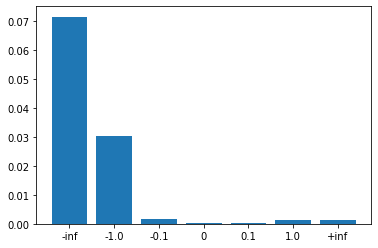

In [104]:
# scores = [1570.4590174100695, 1369.284425737816, 202.22367176732857, 21.960276998301005, 11.416660023420379, 51.877976428710376, 80.21474204099708]
scores = [1427.704272155762, 603.7175203036727, 35.82850944335943, 3.2663348568596553, 8.541073928440824, 22.76504486479415, 24.388492691297834]

q_list = ["-inf", "-1.0", "-0.1", "0", "0.1", "1.0", "+inf"]

plt.bar(q_list, [s/20000 for s in scores])

### Top-1 - Top-9

In [55]:
# main measurement
classes = [i for i in range(10)]
orig_A1, lim_A1 = 2000, 2000

fact_10 = factorial(10)

topk_scores = [info_trans_scoring_4(k, classes, orig_A1, lim_A1) for k in range(9, 0, -1)]

<BarContainer object of 9 artists>

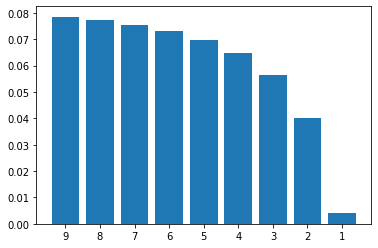

In [64]:
plt.bar([str(k) for k in range(9, 0, -1)], [s/20000 for s in topk_scores])

# 9 classes

<BarContainer object of 7 artists>

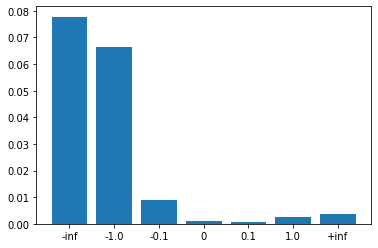

In [110]:
q_list = ["-inf", "-1.0", "-0.1", "0", "0.1", "1.0", "+inf"]
scores_9 = [1555.5882567700587, 1329.6894571170337, 181.33152711880408, 19.384140118964552, 11.631852489757694, 51.77230391086174, 74.96462145498882]
plt.bar(q_list, [s/20000 for s in scores_9])

# 8 classes

<BarContainer object of 7 artists>

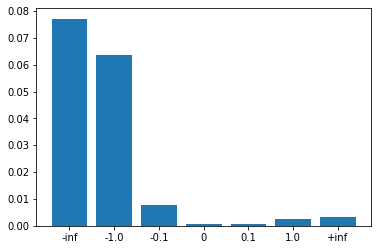

In [111]:
q_list = ["-inf", "-1.0", "-0.1", "0", "0.1", "1.0", "+inf"]
scores_8 = [1542.2931254828206, 1271.1877483368014, 154.09255876500964, 15.779647302905605, 11.204735994795731, 46.953496525728, 65.1533362426509]
plt.bar(q_list, [s/20000 for s in scores_8])

# 7 classes

<BarContainer object of 7 artists>

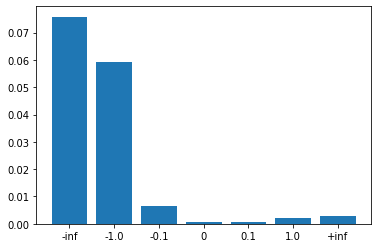

In [112]:
q_list = ["-inf", "-1.0", "-0.1", "0", "0.1", "1.0", "+inf"]
scores_7 = [1516.4067211242652, 1182.6865050604058, 129.17213372687687, 11.841029616757078, 10.676383098354414, 42.02621515628937, 56.092566158697245]
plt.bar(q_list, [s/20000 for s in scores_7])

# 6 classes

<BarContainer object of 7 artists>

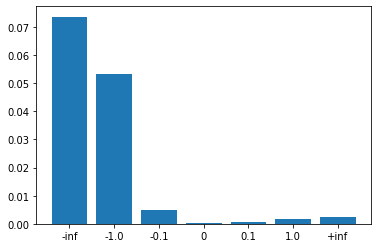

In [113]:
q_list = ["-inf", "-1.0", "-0.1", "0", "0.1", "1.0", "+inf"]
scores_6 = [1473.2930538928615, 1067.9406555912135, 97.55444210113329, 8.154757968500478, 10.048518539218902, 37.61693474677773, 47.058528250835444]
plt.bar(q_list, [s/20000 for s in scores_6])

# 5 classes

<BarContainer object of 7 artists>

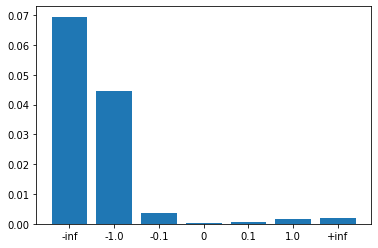

In [114]:
q_list = ["-inf", "-1.0", "-0.1", "0", "0.1", "1.0", "+inf"]
scores_5 = [1389.7177973534626, 890.7014743890136, 70.5196813882286, 5.628622726913633, 10.127832220175724, 34.428600265252264, 40.44477887225204]
plt.bar(q_list, [s/20000 for s in scores_5])

# 4 classes

<BarContainer object of 7 artists>

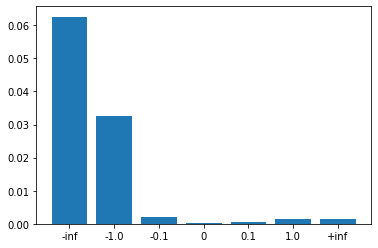

In [115]:
q_list = ["-inf", "-1.0", "-0.1", "0", "0.1", "1.0", "+inf"]
scores_4 = [1251.726178401893, 648.590363346986, 42.8169948029854, 3.3768562823988812, 9.611921211463438, 26.97396850360082, 29.089156746804136]
plt.bar(q_list, [s/20000 for s in scores_4])

# 3 classes

<BarContainer object of 7 artists>

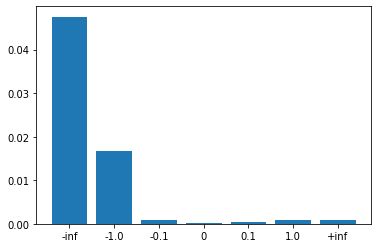

In [116]:
q_list = ["-inf", "-1.0", "-0.1", "0", "0.1", "1.0", "+inf"]
scores_3 = [950.7584503919611, 335.7266746430469, 16.8803753067687, 2.353741111716643, 8.93939981047482, 16.317492225851062, 16.460482084954865]
plt.bar(q_list, [s/20000 for s in scores_3])

# 2 classes

<BarContainer object of 7 artists>

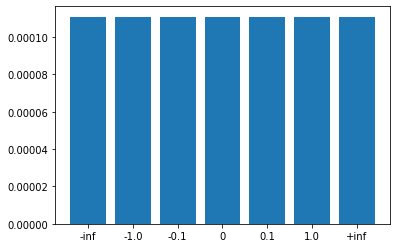

In [117]:
q_list = ["-inf", "-1.0", "-0.1", "0", "0.1", "1.0", "+inf"]
scores_2 = [2.216902678356755, 2.216902678356755, 2.216902678356755, 2.216902678356755, 2.216902678356755, 2.216902678356755, 2.216902678356755]
plt.bar(q_list, [s/20000 for s in scores_2])